## 1. Import Dependencies

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 2. Load in Reviews and EDA

### 2.1 Load in Review Data which has undergone sentiment analysis

In [200]:
df = pd.read_csv('sentimentanalysidata.csv')
df['date'] = pd.to_datetime(df['date'])
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [201]:
def condition(x):
    if x > 30:
        return 'positive'
    elif x < 30:
        return 'negative'
    else:
        return 'neutral'
df['basic_sentiment'] = df['sentiment_transformed'].apply(condition)

In [202]:
df_qts = df.loc[df['airline']=='qantas']
df_sa = df.loc[df['airline']=='singapore']

Text(0.5, 1.0, 'Number of Reviews over Time Period')

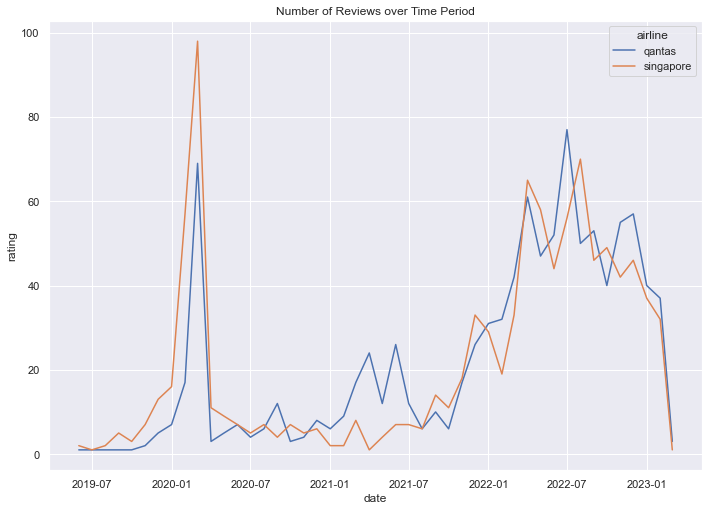

In [203]:
sns.lineplot(data = df.groupby(['date','airline']).agg({"rating":"count"}).reset_index(),x='date',y='rating',hue='airline')
plt.title('Number of Reviews over Time Period')

### 2.2 Complete high level analysis of ratings

In [204]:
print(f'For Qantas, we have {df_qts.shape[0]} reviews and for Singapore Airlines we have {df_sa.shape[0]} reviews')

For Qantas, we have 1005 reviews and for Singapore Airlines we have 1005 reviews


In [205]:
def stacked_bar_chart(df,airline,index, column, category):
    df = df.loc[df['airline']==airline]
    cross_tab_prop = pd.crosstab(
                            index=df[index],
                             columns=df[column],
                             normalize="index"
                            )
    cross_tab_prop.plot(
                    kind='barh', 
                    stacked=True, 
                    colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
                    figsize=(15, 6)
                       )
    plt.legend(loc='upper right')
    plt.title(f'{airline} airline rating distribution by {category}')
    plt.xticks(rotation=0)

Text(0.5, 1.0, 'Number of Reviews by Cabin Class')

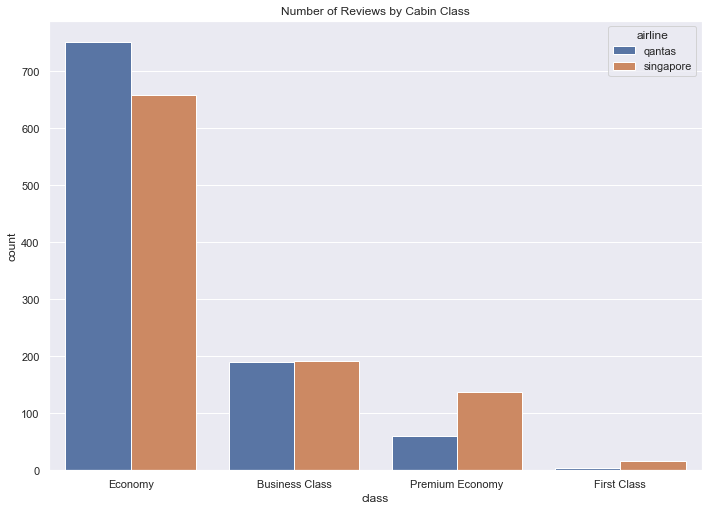

In [206]:
sns.countplot(data=df,x='class', hue='airline')
plt.title('Number of Reviews by Cabin Class')

In [207]:
print(f'Average rating for Singapore is {df_sa["sentiment"].mean()} & the average rating for Qantas is {df_qts["sentiment"].mean()}')

Average rating for Singapore is 2.3064676616915425 & the average rating for Qantas is 1.918407960199005


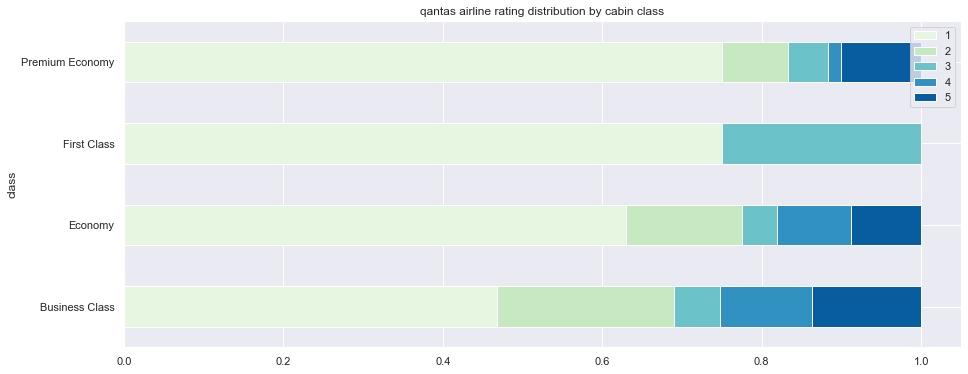

In [208]:
stacked_bar_chart(df,'qantas','class','sentiment','cabin class')

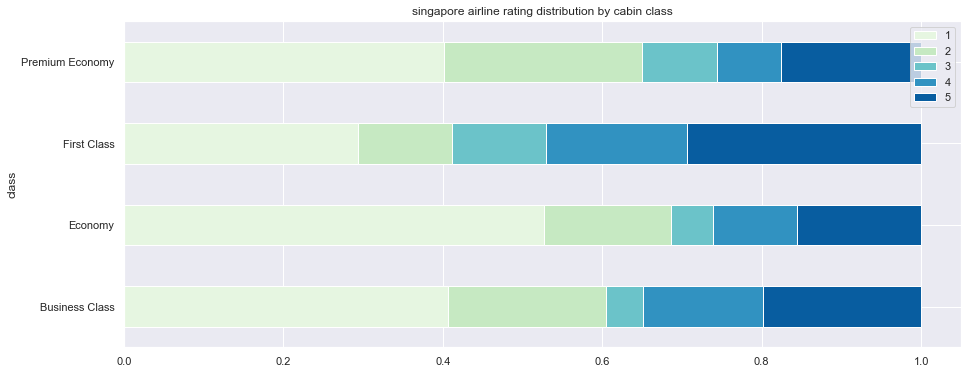

In [209]:
stacked_bar_chart(df,'singapore','class','sentiment','cabin class')

[Text(0.5, 1.0, 'Average Rating By Class')]

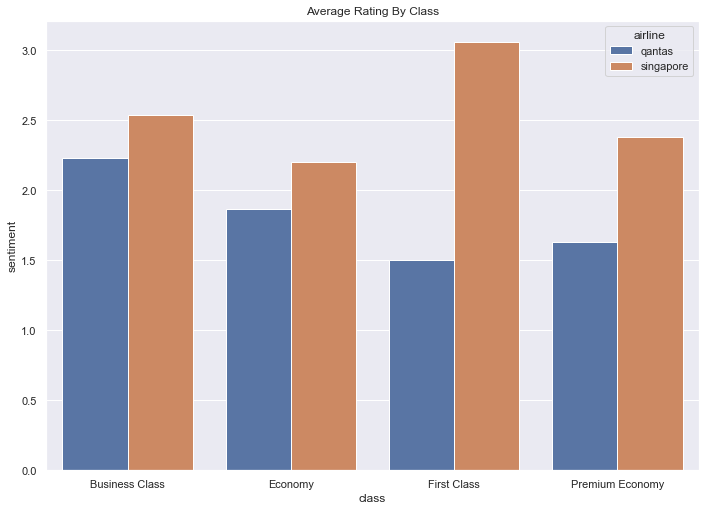

In [210]:
sns.barplot(data=df.groupby(['airline','class']).agg({"sentiment":"mean"}).reset_index(),x='class',y='sentiment',hue='airline').set(title='Average Rating By Class')

<AxesSubplot:xlabel='date', ylabel='sentiment'>

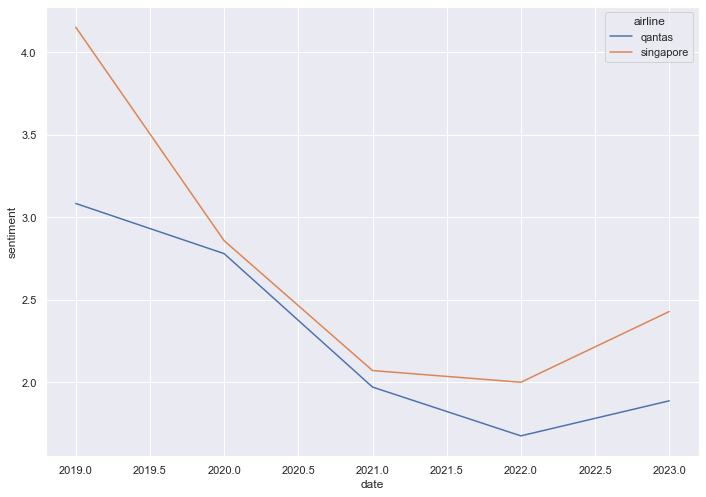

In [211]:
## Sentiment over time
sns.lineplot(data = df.groupby([df.date.dt.year,'airline']).agg({"sentiment":"mean"}).reset_index(),x='date',y='sentiment',hue='airline')

### 2.3 Analysis of Reviews

In [212]:
text_qts = " ".join(review for review in df_qts.loc[df_qts['rating']>0].review)
text_sa = " ".join(review for review in df_sa.loc[df_sa['rating']>0].review)

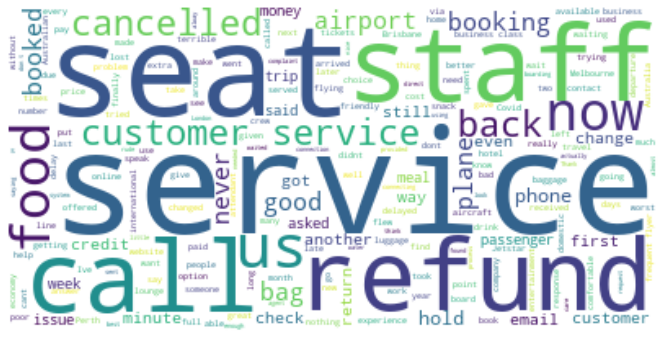

In [213]:
from wordcloud import WordCloud, STOPWORDS
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['flight','Qantas','Singapore','Airline','flights','airlines','will','ticket','told','fly', 'hour','hours','time','One', 'Sydney','u','day'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_qts)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

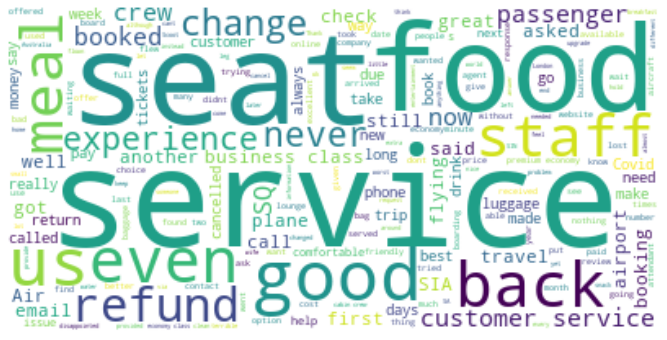

In [214]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_sa)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The biggest categories for bad reviews are:
- Service
- Seat/Comfort
- Refund
- Food
- Call (Customer service)
- Cancellation
- Cost/Money

All of these categories should be added to the zero shot classifier. In addition, the following could be added:
- Delays
- Communication

In [215]:
for topic in ['service','comfort','refund','food','communication','cancellation','cost','delays']:
    df[f'{topic}_flag'] = df[topic].apply(lambda x: 1 if x > 0.9 else 0)

Text(0.5, 1.0, 'Topic Count in Reviews')

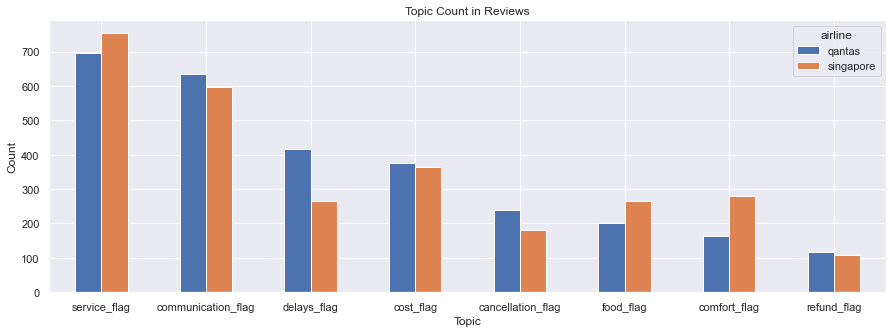

In [216]:
df.groupby('airline')[['service_flag', 'comfort_flag', 'refund_flag',
       'food_flag', 'communication_flag', 'cancellation_flag', 'cost_flag',
       'delays_flag']].sum().transpose().sort_values(by='qantas',ascending=False).plot(kind='bar',figsize=(15,5))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Topic')
plt.title('Topic Count in Reviews')

In [217]:
topics = ['service','comfort','refund','food','communication','cancellation','cost','delays']
df['main_topic'] = df[topics].idxmax(axis=1)

Text(0.5, 1.0, 'Count of the Top Theme within each Review')

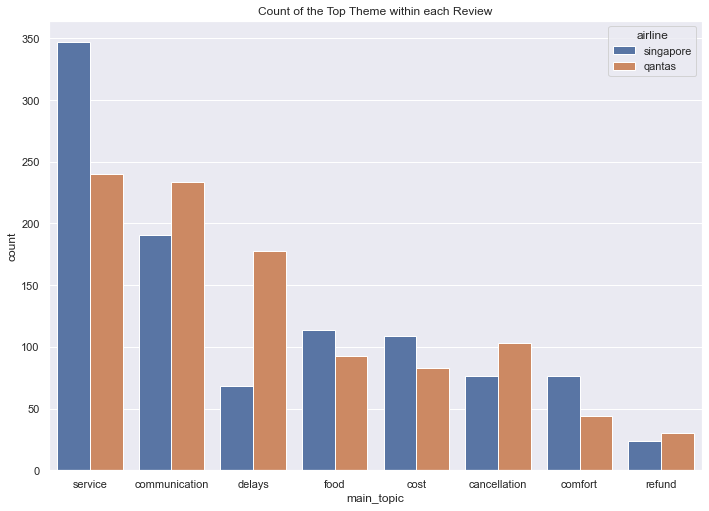

In [218]:
sns.barplot(data = df.groupby(['main_topic','airline']).agg({"review":"count"}).reset_index().rename(columns={"review":"count"}).sort_values(by='count',ascending=False),x='main_topic',y='count',hue='airline')
plt.title('Count of the Top Theme within each Review')

In [227]:
df.loc[df['airline']=='qantas'].groupby('main_topic').agg({"sentiment":"mean"}) - df.loc[df['airline']=='singapore'].groupby('main_topic').agg({"sentiment":"mean"}) 

,sentiment
main_topic,
cancellation,-0.105902
comfort,0.159091
communication,-0.023762
cost,-0.053609
delays,-0.006940
food,-0.051500
refund,0.033333
service,-0.356628


In [224]:
df.groupby(['airline','main_topic']).agg({"sentiment":"mean"}).reset_index()

,airline,main_topic,sentiment
0,qantas,cancellation,1.038835
1,qantas,comfort,4.159091
2,qantas,communication,1.384615
3,qantas,cost,1.506024
4,qantas,delays,1.522472
5,qantas,food,2.387097
6,qantas,refund,1.200000
7,qantas,service,2.750000
8,singapore,cancellation,1.144737
9,singapore,comfort,4.000000


Text(0, 0.5, 'Sentiment Rating')

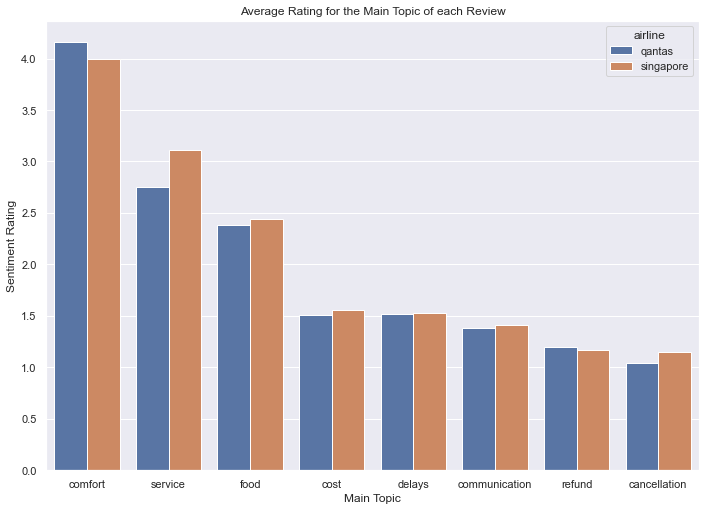

In [219]:
sns.barplot(data = df.groupby(['airline','main_topic']).agg({"sentiment":"mean"}).reset_index().sort_values(by='sentiment',ascending=False),x='main_topic',y='sentiment',hue='airline')
plt.title('Average Rating for the Main Topic of each Review')
plt.xlabel('Main Topic')
plt.ylabel('Sentiment Rating')

Text(0, 0.5, 'Main Topic')

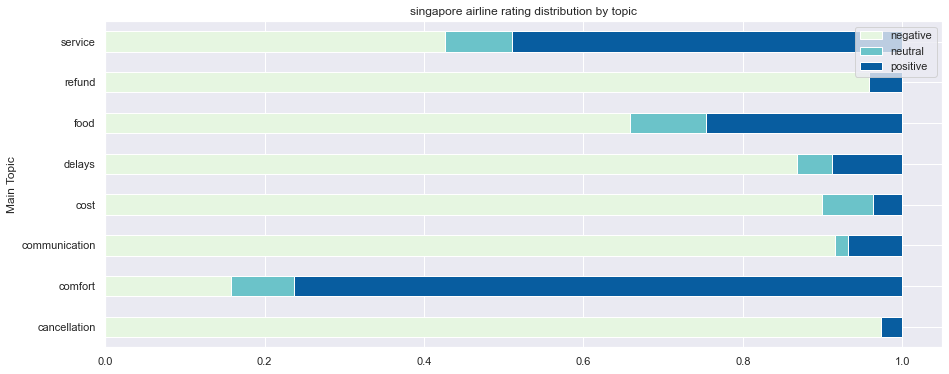

In [228]:
stacked_bar_chart(df,'singapore','main_topic','basic_sentiment', 'topic')
plt.ylabel('Main Topic')

Text(0, 0.5, 'Main Topic')

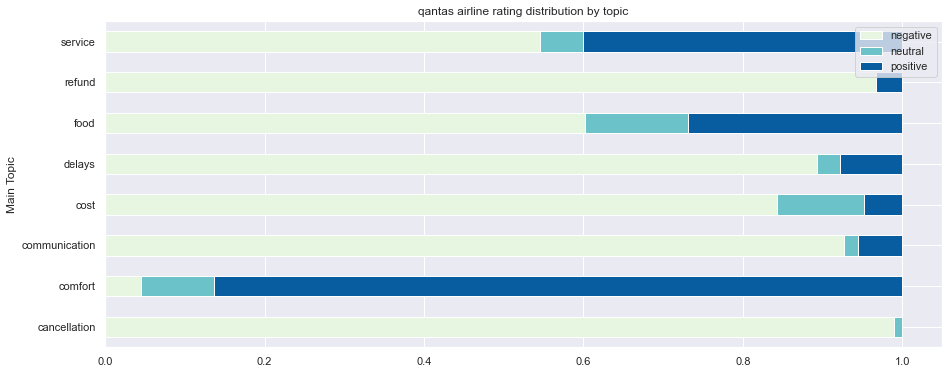

In [229]:
stacked_bar_chart(df,'qantas','main_topic','basic_sentiment', 'topic')
plt.ylabel('Main Topic')

In [236]:
df.loc[(df['airline']=='singapore') & (df['main_topic']=='cancellation') & (df['sentiment'] >= 4)]['review'][1806]

'Flights from London to Bali via Singapore were cancelled, within 2 weeks of contacting Singapore airlines, refund received in full. Amazing customer service, 2 phone calls from their office to keep me fully informed..... will 100% book again!!'

In [240]:
df.loc[(df['airline']=='singapore') & (df['main_topic']=='cancellation') & (df['sentiment'] >= 4)]['review'][1837]

'Wonderful service on our trip out to New Zealand via Singapore, flight left and arrived on time, check in was easy and smooth. Sadly, Singapore cancelled their flights from Christchurch, NZ, before we were due to leave due to the pandemic and were still waiting for a refund (2 months on). If not for this, we would mark them up to 5 stars.'

 ---------------------------

## Analysis of Service Reviews

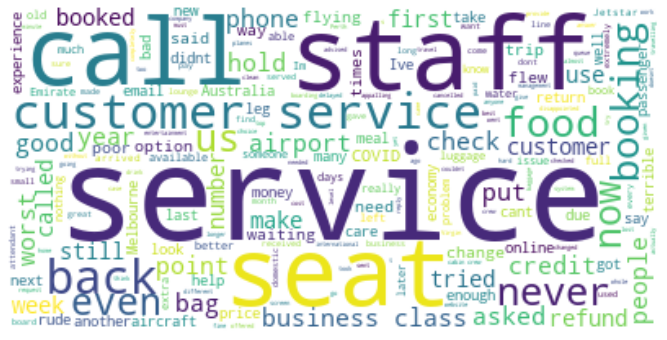

In [254]:
from wordcloud import WordCloud, STOPWORDS
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['flight','Qantas','Singapore','Airline','flights','airlines','will','ticket','told','fly', 'hour','hours','time','One', 'Sydney','u','day','plane'])

text_qts_service = " ".join(review for review in df.loc[(df['sentiment']<3) & (df['airline']=='qantas') & (df['main_topic']=='service')].review)
text_sa_service = " ".join(review for review in df.loc[(df['sentiment']<3) & (df['airline']=='singapore') & (df['main_topic']=='service')].review)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_qts_service)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

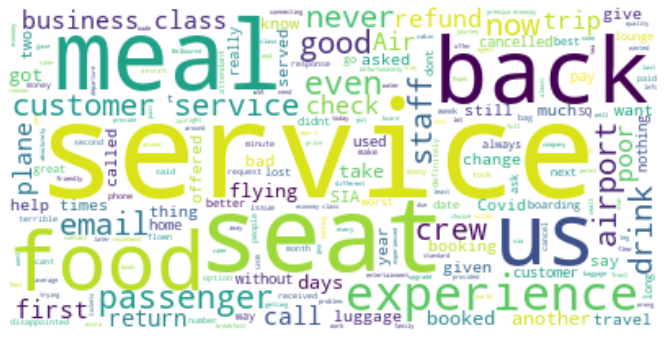

In [249]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_sa_service)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [263]:
df.columns

Index(['date', 'class', 'rating', 'review', 'airline', 'service', 'comfort',
       'refund', 'food', 'communication', 'cancellation', 'cost', 'delays',
       'sentiment', 'sentiment_transformed', 'sentiment_similarity',
       'basic_sentiment', 'service_flag', 'comfort_flag', 'refund_flag',
       'food_flag', 'communication_flag', 'cancellation_flag', 'cost_flag',
       'delays_flag', 'main_topic'],
      dtype='object')

Text(0, 0.5, 'Proportion of Reviews where Service is the Main Topic')

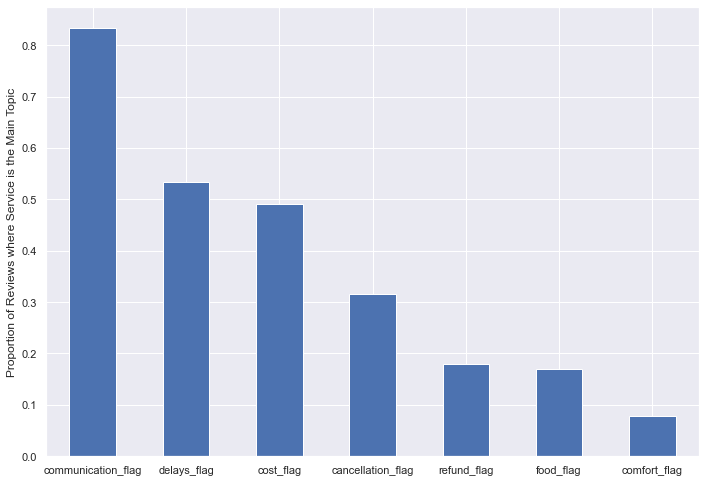

In [269]:
df.loc[(df['sentiment']<3) & (df['airline']=='qantas') & (df['service_flag']==1)][['comfort_flag', 'refund_flag', 'food_flag', 'communication_flag', 'cancellation_flag', 'cost_flag','delays_flag']].mean().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Proportion of Reviews where Service is the Main Topic')